# Estimation of Covariance Matrices.
By Christopher van Hoecke and Max Margenot.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

Volatility has long been a thorn in the side of investors in the market. Successfully measuring volatility would allow for more accurate modeling of the returns and more stable investments leading to greater returns, but forecasting volatility accurately is a difficult problem. 

## Measuring Volatility

Volatility needs to be forward-looking and predictive in order to make smart decisions. Unfortunately, simply taking the historical standard deviation of an individual asset's returns falls short when we take into account need for robustness to the future. When we scale the problem up to the point where we need to forecast the volatility for many assets, it gets even harder.

To model how a portfolio overall changes, it is important to look not only at the volatility of each asset in the portfolio, but also at the pairwise covariances of every asset involved. The relationship between two or more assets provides valuable insights and a path towards reduction of overall portfolio volatility. A large number of assets with low covariance would assure they decrease or increase independently of each other. Indepedent assets have less of an impact on our portfolio's volatility as they give us true diversity and help us avoid [position concentration risk](https://www.quantopian.com/lectures/position-concentration-risk).

## Covariance

In statistics and probability, the covariance is a measure of the joint variability of two random variables. When random variables exhibit similar behavior, there tends to be a high covariance between them. Mathematically, we express the covariance of X with respect to Y as:

$$ COV(X, Y) = E[(X - E[X])(Y - E[Y])]$$

Notice that if we take the covariance of $X$ with itself, we get:

$$ COV(X, X) = E[(X - E[X])(X - E[X])] = E[(X - E[X])^2] = VAR(X) $$

We can use covariance to quantify the similarities between different assets in much the same way. If two assets have a high covariance, they will generally behave the same way. Assets with particularly high covariance can essentially replace each other.

Covariance matrices form the backbone of Modern Portfolio theory (MPT). MPT focuses on maximizing return for a given level of risk, making essential the methods with which we estimate that risk. We use covariances to quantify the joint risk of assets, forming how we view the risk of an entire portfolio. What is key is that investing in assets that have high pairwise covariances provides little diversification because of how closely their fluctuations are related.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import covariance

Let's take the covariance of two closely related variables, $X$ and $Y$. Say that $X$ is some randomly drawn set and that $Y =  5X + \epsilon$, where $\epsilon$ is some extra noise. We can compute the covariance using the formula above to get a clearer picture of how $X$ evolves with respect to asset $Y$.

In [2]:
# Generate random values of x
X = np.random.normal(size = 1000)
epsilon = np.random.normal(0, 3, size = len(X))
Y = 5*X + epsilon

product = (X - np.mean(X))*(Y - np.mean(Y))
expected_value = np.mean(product)

print 'Value of the covariance between X and Y:', expected_value

Value of the covariance between X and Y: 4.79184773461


We can also compute the covariance between $X$ and $Y$ with a single function.

In [3]:
np.cov([X, Y])

array([[  0.96347712,   4.79664438],
       [  4.79664438,  32.52139565]])

This gives us the covariance matrix between $X$ and $Y$. The diagonals are their respective variances and the indices $(i, j)$ refer to the covariance between assets indexed $i$ and $j$.

In [4]:
print np.var(X), np.var(Y)

0.962513639625 32.4888742558


In this case, we only have two assets so we only have indices $(0, 1)$ and $(1, 0)$. Covariance matrices are symmetric, since $COV(X, Y) = COV(Y, X)$, which is why the off-diagonals mirror each other.

We can intuitively think of this as how much $Y$ changes when $X$ changes and vice-versa. As such, our covariance value of about 5 could have been anticipated from the definition of the relationship between $X$ and $Y$.

Here is a scatterplot between $X$ and $Y$ with a line of best fit down the middle.

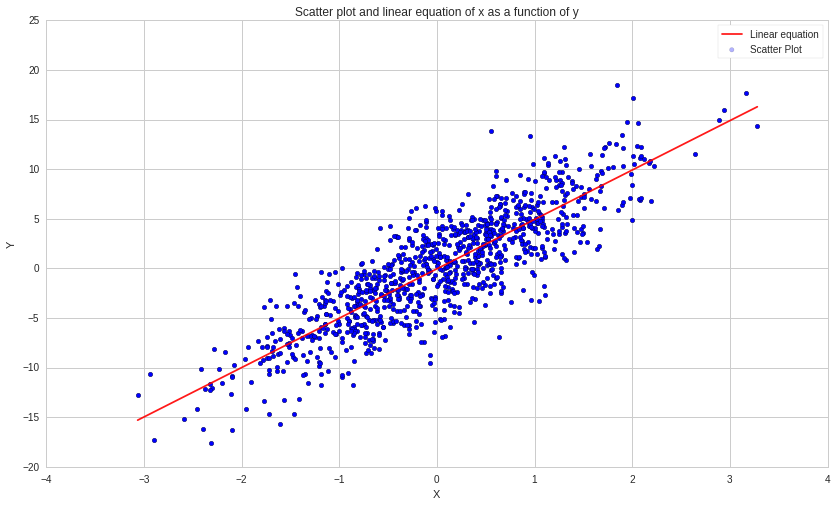

In [5]:
# scatter plot of X and y
from statsmodels import regression
import statsmodels.api as sm
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

linreg(X, Y)
plt.scatter(X, Y)
plt.title('Scatter plot and linear equation of x as a function of y')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Linear equation', 'Scatter Plot']);

Between the covariance, the linear regression, and our knowledge of how $X$ and $Y$ are related, we can easily assess the relationship between our toy variables. With real data, there are two main complicating factors. The first is that we are exmaining significantly more relationships. The second is that we do not know any of their underlying relationships. These hindrances speak to the benefit of having accurate estimates of covariance matrices.

## The Covariance Matrix

As the number of assets we are curious about increases, so too do the dimensions of the covariance matrix that describes their relationships. If we take the covariance between $N$ assets, we will get out a $N \times N$ covariance matrix. This allows us to efficiently express the relationships between many arrays at once. As with the simple $2\times 2$ case, the $i$-th diagonal is the variance of the $i$-th asset and the values at $(i, j)$ and $(j, i)$ refer to the covariance between asset $i$ and asset $j$. We display this with the following notation:

$$ \Sigma = \left[\begin{matrix}
VAR(X_1) & COV(X_1, X_2) & \cdots & COV(X_1, X_N) \\
COV(X_2, X_0) & VAR(X_2) & \cdots & COV(X_2, X_N) \\
\vdots & \vdots & \ddots & \vdots \\
COV(X_N, X_1) & COV(X_N, X_2) & \cdots & VAR(X_N)
\end{matrix}\right] $$  

When trying to find the covariance of many assets, it quickly becomes apparent why the matrix notation is more favorable. 

In [6]:
# Four asset example of the covariance matrix.
start_date = '2016-01-01'
end_date = '2016-02-01'

returns = get_pricing(
    ['SBUX', 'AAPL', 'GS', 'GILD'],
    start_date=start_date,
    end_date=end_date,
    fields='price'
).pct_change()[1:]
returns.columns = map(lambda x: x.symbol, returns.columns)

print 'Covariance matrix:'
print returns.cov()

Covariance matrix:
          SBUX      AAPL        GS      GILD
SBUX  0.000453  0.000330  0.000331  0.000075
AAPL  0.000330  0.000739  0.000463  0.000237
GS    0.000331  0.000463  0.000533  0.000130
GILD  0.000075  0.000237  0.000130  0.000569


## Why does all this matter?  

We measure the covariance of the assets in our portfolio to make sure we have an accurate picture of the risks involved in holding those assets togther. We want to apportion our capital amongst these assets in such a way as to minimize our exposure to the risks associated with each individual asset and to neutralize exposure to systematic risk. This is done through the process of portfolio optimization. Portfolio optimization routines go through exactly this process, finding the appropriate weights for each asset given its risks. Mean-variance optimization, a staple of MPT, does exactly this. 

Estimating the covariance matrix becomes critical when using methods that rely on it, as we cannot know the true statistical relationships underlying our chosen assets. The stability and accuracy of these estimates are essential to getting stable weights that encapsulate our risks and intentions.

Unfortunately, the most obvious way to calculate a covariance matrix estimate, the sample covariance, is notoriously unstable. If we have fewer time observations of our assets than the number of assets ($T < N$), the estimate becomes especially unreliable. The extreme values react more strongly to changes, and as the extreme values of the covariance jump around, our optimizers are perturbed, giving us inconsistent weights. This is a problem when we are trying to make many independent bets on many assets to improve our risk exposures through diversification. Even if we have more time elements than assets that we are trading, we can run into issues, as the time component may span multiple regimes, giving us covariance matrices that are still inaccurate.

The solution in many cases is to use a robust formulation of the covariance matrix. If we can estimate a covariance matrix that still captures the relationships between assets and is simultaneously more stable, then we can have more faith in the output of our optimizers. A main way that we handle this is by using some form of a shrinkage estimator.

# Shrinkage Estimators

The concept of shrinkage stems from the need for stable covariance matrices. The basic way we "shrink" a matrix is to reduce the extreme values of the sample covariance matrix by pulling them closer to the center. Practically, we take a linear combination of the sample covariance covariance matrix a constant array representing the center.

Given a sample covariance matrix, $\textbf{S}$, the mean variance, $\mu$, and the shrinkage constant $\delta$, the shrunk estimated covariance is mathematically defined as:   

$$(1 - \delta)\textbf{S} + \delta\mu\textbf{1}$$  
 
We restrict $\delta$ such that $0 \leq \delta \leq 1$ making this a weighted average between the sample covariance and the mean variance matrix. The optimal value of $\delta$ has been tackled several times. For our purposes, we will use the formulation by Ledoit and Wolf.

## Ledoit-Wolf Estimator.

In [their paper](http://ledoit.net/honey.pdf), Ledoit and Wolf  proposed an optimal $\delta$ as 

$$\hat\delta^* \max\{0, \min\{\frac{\hat\kappa}{T},1\}\}$$

$\hat\kappa$ has a mathematical formulation that is beyond the scope of this lecture, but you can find its definition in the paper.

The Ledoit-Wolf Estimator is the robust covariance estimate that uses this optimal $\hat\delta^*$ to shrink the sample covariance matrix. We can draw an implementation of it directly from scikit-learn for easy use. The scikit implementation calculates the shrinkage constant as well as the shrunk covariance matrix. We use this in the following examples to demonstrate its stability.

In [7]:
# Getting the return data of assets. 
start = '2016-01-01'
end = '2016-02-01'

symbols = ['AAPL', 'MSFT', 'BRK-A', 'GE', 'FDX', 'SBUX']

prices = get_pricing(symbols, start_date = start, end_date = end, fields = 'price')
prices.columns = map(lambda x: x.symbol, prices.columns)
returns = prices.pct_change()[1:]

In [8]:
returns.head()

,AAPL,MSFT,BRK_A,GE,FDX,SBUX
2016-01-05 00:00:00+00:00,-0.024969,0.004745,0.001934,0.000651,0.008526,0.006522
2016-01-06 00:00:00+00:00,-0.019474,-0.017711,0.003365,-0.015935,-0.026958,-0.008697
2016-01-07 00:00:00+00:00,-0.041311,-0.034674,-0.011251,-0.041970,-0.044043,-0.024772
2016-01-08 00:00:00+00:00,0.004558,0.002682,-0.008396,-0.018972,0.000817,-0.000882
2016-01-11 00:00:00+00:00,0.015983,-0.000764,-0.003227,0.004923,-0.012697,0.020833


Now that we have our in and out of sample returns for the 6 assets, we can set about calcualting the two shrunk covariance matrices: The in and out of sample ones . 

In [9]:
in_sample_lw = covariance.ledoit_wolf(returns)[0]
print in_sample_lw

[[ 0.00065499  0.00041175  0.00014706  0.0001944   0.00028022  0.00026144]
 [ 0.00041175  0.00050599  0.00016123  0.00022653  0.00033813  0.00022635]
 [ 0.00014706  0.00016123  0.00019215  0.00012305  0.00016825  0.0001618 ]
 [ 0.0001944   0.00022653  0.00012305  0.00032382  0.00021071  0.00023099]
 [ 0.00028022  0.00033813  0.00016825  0.00021071  0.00045808  0.00024686]
 [ 0.00026144  0.00022635  0.0001618   0.00023099  0.00024686  0.00042922]]


### Calculating Errors
We can quantify the variance between the in and out of sample matrices by taking the mean difference element-by-element for the two matrices. We represent it mathematically as: 
$$
\frac{1}{n} \sum_{i=1}^{n} |a_i - b_i|
$$

In [10]:
oos_start = '2016-02-01'
oos_end = '2016-03-01'
oos_prices = get_pricing(symbols, start_date = oos_start, end_date = oos_end, fields = 'price')
oos_prices.columns = map(lambda x: x.symbol, oos_prices.columns)
oos_returns = oos_prices.pct_change()[1:]
out_sample_lw = covariance.ledoit_wolf(oos_returns)[0]

In [11]:
lw_error = np.mean(sum(abs(np.subtract(in_sample_lw, out_sample_lw))))
print "Average LW Error: ", lw_error

Average LW Error:  0.000543690949796


### Comparing to Sample Matrix
We can check the validity of the shrinkage technique by comparing the results for the shrunk covariance matrix to that of the sample one which we calculate bellow.

In [12]:
sample_error = np.mean(sum(abs(np.subtract(returns.cov().values, oos_returns.cov().values))))
print 'Mean error associated with the sample covariance matrix:', sample_error

Mean error associated with the sample covariance matrix: 0.000646608903348


We can see that the mean error associated with the Ledoit-Wolf shrunk matrix is smaller than that of the sample shrunk covariance by a factor of about 10. This translates into decreased volatility and turnover rate in our portfolio, and thus increased returns when using the shrunk covariance matrix. 

In [13]:
# Calculate the mean error associated with the sample and shrunk matrix. 
sample_error = sum(abs(np.subtract(returns.cov().values, oos_returns.cov().values)))
print 'Mean error for the Sample Covariance matrix:', np.mean(sample_error)

lw_error = sum(abs(np.subtract(in_sample_lw, out_sample_lw)))
print 'Mean error in the Ledoit-Wolf Shrunk covariance matrix:', np.mean(lw_error)

Mean error for the Sample Covariance matrix: 0.000646608903348
Mean error in the Ledoit-Wolf Shrunk covariance matrix: 0.000543690949796


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


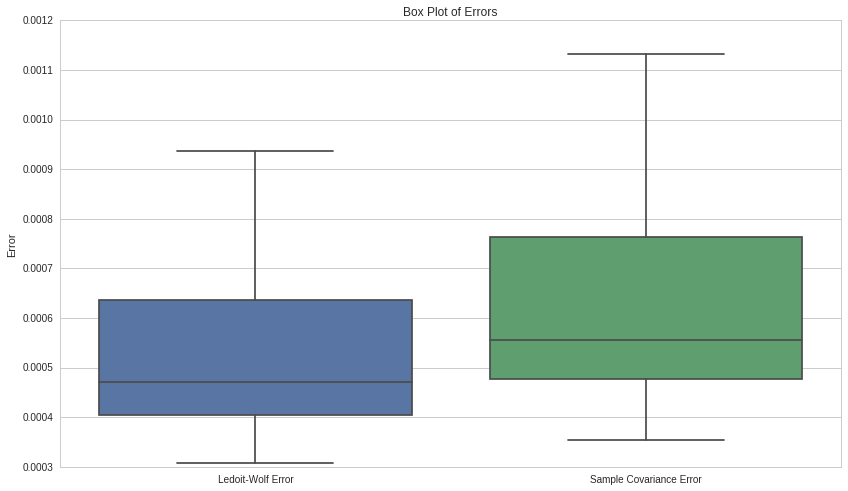

In [14]:
errors = [sample_error, lw_error]

sns.boxplot(
    pd.DataFrame({
        'Sample Covariance Error': sample_error,
        'Ledoit-Wolf Error': lw_error
    })
)
plt.title('Box Plot of Errors')
plt.ylabel('Error');

In [15]:
start_date = '2016-01-01'
end_date = '2017-06-01'

symbols = [
    'SPY', 'XLF', 'XLE', 'XLU','XLK', 'XLI', 'XLB', 'GE', 'GS', 'BRK-A', 'JPM', 'AAPL', 'MMM', 'BA',
    'CSCO','KO', 'DIS','DD', 'XOM', 'INTC', 'IBM', 'NKE', 'MSFT', 'PG', 'UTX', 'HD', 'MCD', 'CVX', 
    'AXP','JNJ', 'MRK', 'CAT', 'PFE', 'TRV', 'UNH', 'WMT', 'VZ', 'QQQ', 'BAC', 'F', 'C', 'CMCSA',
    'MS', 'ORCL', 'PEP', 'HON', 'GILD', 'LMT', 'UPS', 'HP', 'FDX', 'GD', 'SBUX'
]

prices = get_pricing(symbols, start_date=start_date, end_date=end_date, fields='price')
prices.columns = map(lambda x: x.symbol, prices.columns)
returns = prices.pct_change()[1:]

In [16]:
dates = returns.resample('1M').index

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  """Entry point for launching an IPython kernel.


In [17]:
sample_covs = []
lw_covs = []

for i in range(1, len(dates)):
    sample_cov = returns[dates[i-1]:dates[i]].cov().values
    sample_covs.append(sample_cov)
    
    lw_cov = covariance.ledoit_wolf(returns[dates[i-1]:dates[i]])[0]
    lw_covs.append(lw_cov)      

In [18]:
lw_diffs = []
for pair in zip(lw_covs[:len(lw_covs)], lw_covs[1:]):
    diff = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    lw_diffs.append(diff)
    
sample_diffs = []
for pair in zip(sample_covs[:len(sample_covs)], sample_covs[1:]):
    diff = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    sample_diffs.append(diff)

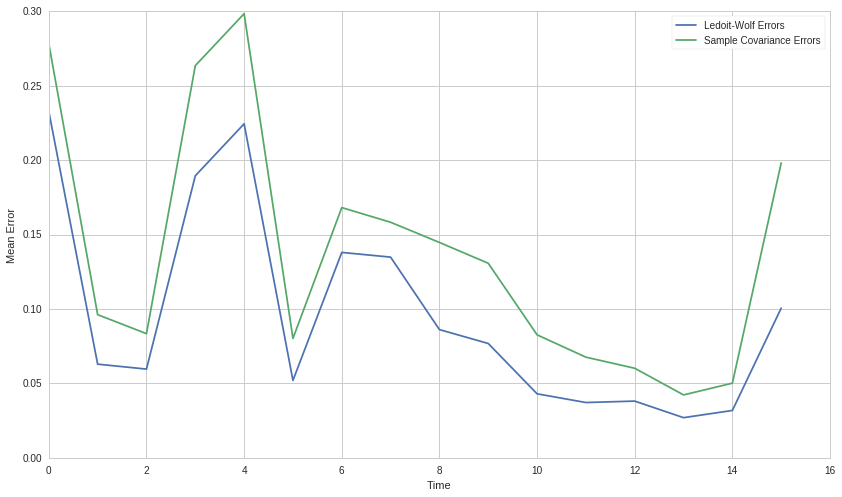

In [19]:
plt.plot(lw_diffs)
plt.plot(sample_diffs)
plt.xlabel('Time')
plt.ylabel('Mean Error')
plt.legend(['Ledoit-Wolf Errors', 'Sample Covariance Errors']);

We can see that the mean errors associated with the shrunk techniques are lower than those of the sample.  
This shows us that the sample matrix is more unstable than that of the shrunk ones, and that shrinking the covariance matrix in the case of mean-variance optimization would lead to better returns as a direct consequence of decreased turnover rates.

Note : Our example only used 50 assets, in the event of even more assets, comparable to outcomes of an algorithm, the Ledoit-Wolf estimator would likely perform even better as the number of assets approaches the number of observations.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*